In [1]:
# Code Adapted from https://github.com/a-martyn/ISL-python
# Comments by Soumitra Pandit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import itertools
from IPython.display import display, HTML
from sklearn import linear_model
from sklearn.model_selection import KFold
from ipywidgets import interact
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact
import ipywidgets as widgets

# Deps for pca/pcr
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from scipy import stats

**Plan**\
The idea is to write a description of how I would execute the code. The descriptions won't match the actual code as I am not accounting for the use of any libraries and I am just trying to form a loose verbose solution. Most of the code here has been borrowed from an online repository as this exercise truly had a lot of foreign functions so I have tried to offset that by thinking through my solutions for problems.

**a)**\
I doubt we have an r-norm function in Pyton. But I am pretty sure that some library does have that. So I'll use that here. The noise can be added using a similar random number generator within a certain range, I am sure. But I want to make sure the random numbers generated are truly random so maybe I will create a list, and then append that list in a loop where the loop calls in the random number generator. As the two calls to the random function are not within the same loop cycle, they will truly be random.

In [2]:
np.random.seed(1)
x   = np.random.normal(0, 1, 100)
eps = eps = np.random.normal(0 ,1 , 100)

**b)**
Okay, this is pretty starightforward. I can just create a list of Yi's where every Y is determined by the function acting on my list of Xi's and then adding the noise to it. lets see how that works.

In [3]:
y_np = 2 + 2*x + 3*(x**2) + 2.5*(x**3) + eps

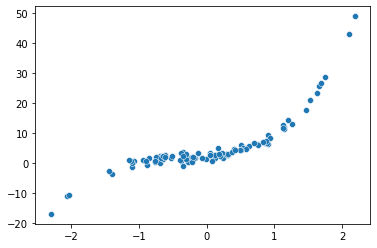

In [4]:
sns.scatterplot(x=x, y=y_np);

**c)**\
This is where stuff gets interesting. I am absolutely sure that there must be some library for best subset selection but I am sure I can just make that function on my own. I am aware that it is going to have exponential time complexity but we are dealing with only 10 estimators so that shouldn't be too bad. I would absolutely refrain from using best subset selection with anything more than 30 predictors though.
I am also supposed to plot the evidence and create a single data frame containing X and Y.
Okay, lets see.

In [ ]:
# Pseudocode
# for i goes from 1 to 10
# from the set of possible predictors (X, X^2...X^10)
# make combinations of i elements
# find the R^2 statistic of the combinations
# find the one with the highest R^2 and store that combination
# Repeat it for all possible subsets
# For j in the thus curated best sub - subset list
# Find the one with the best 
# a) Cp 
# b) BIC
# c) adjusted R^2
# plot the graphs for the three models thus obtained
# Save results in a dataframe

In [5]:
def get_models(k, X, y):
    """
    Fit all possible models that contain exactly k predictors.
    """
    # List all available predictors
    X_combos = itertools.combinations(list(X.columns), k)
    
    # Fit all models accumulating Residual Sum of Squares (RSS)
    models = []
    for X_label in X_combos:
        # Parse patsy formula
        X_smf = ' + '.join(X_label)
        f     = '{} ~ {}'.format(y.columns[0], X_smf)
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Return results
        models += [(f, model)]
    return models


def min_rss(statsmodels):
    """Return model with lowest Residual Sum of Squares (RSS)"""
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]


def max_adjr2(statsmodels):
    """Return model with max R-squared"""
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]

def min_bic(statsmodels):
    """Return model with min Bayes' Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

def min_aic(statsmodels):
    """Return model with min Akaike's Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].aic)[0]
X = pd.DataFrame({'X': x,
                  'X2': x**2,
                  'X3': x**3,
                  'X4': x**4,
                  'X5': x**5,
                  'X6': x**6,
                  'X7': x**7,
                  'X8': x**8,
                  'X9': x**9,
                  'X10': x**10})
y = pd.DataFrame({'y': y_np})

# get all model results
model_subsets = []
for k in range(len(X.columns)):
    k=k+1
    subset = get_models(k, X, y)
    model_subsets += [subset]
    print('Progess: k = {}, done'.format(k))

Progess: k = 1, done
Progess: k = 2, done
Progess: k = 3, done
Progess: k = 4, done
Progess: k = 5, done
Progess: k = 6, done
Progess: k = 7, done
Progess: k = 8, done
Progess: k = 9, done
Progess: k = 10, done


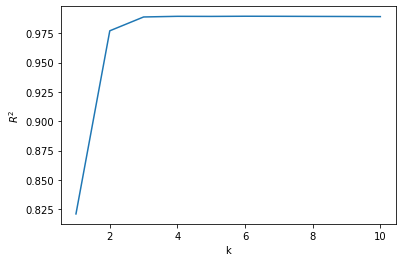

Model selected: 
Intercept    2.298519
X            2.659149
X2           2.617578
X5           2.279830
X7          -0.684882
X9           0.065720
X10          0.001195
dtype: float64


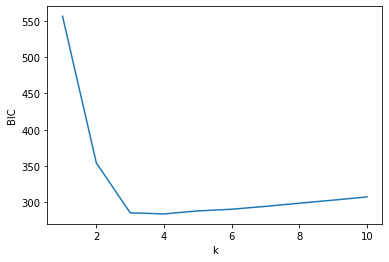

Model selected: 
Intercept    2.276949
X            1.910076
X2           2.657467
X3           2.605378
X6           0.020949
dtype: float64


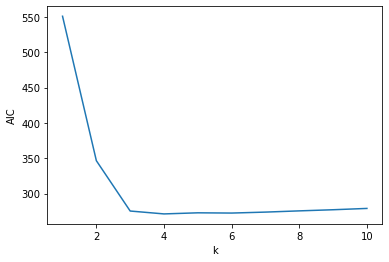

Model selected: 
Intercept    2.276949
X            1.910076
X2           2.657467
X3           2.605378
X6           0.020949
dtype: float64


In [6]:
# Get predictor count
k = np.arange(1, len(X.columns)+1)

# adjr2
# ------------------------------------------------
display(HTML('<h4>Adjusted R^2</h4>'))

# Plot best r-squared score for each subset
adjr2 = [max_adjr2(m)[1].rsquared_adj for m in model_subsets]

sns.lineplot(x=k, y=adjr2)
plt.xlabel('k')
plt.ylabel('$R^2$')
plt.show()

# Select best subset
coefs_r2 = [(max_adjr2(m)[1].rsquared_adj, max_adjr2(m)[1].params) for m in model_subsets]
print('Model selected: \n{}'.format(max(coefs_r2)[1]))


# Bayes' Information Criteria (BIC)
# ------------------------------------------------
display(HTML('<h4>Bayes\' Information Criteria</h4>'))

# Get best BIC
bic = [min_bic(m)[1].bic for m in model_subsets]

sns.lineplot(x=k, y=bic)
plt.xlabel('k')
plt.ylabel('BIC')
plt.show()

# Select best subset
coefs_bic = [(min_bic(m)[1].bic, min_bic(m)[1].params) for m in model_subsets]
print('Model selected: \n{}'.format(min(coefs_bic)[1]))


# Akaike's Information Criteria (AIC/ C_p)
# ------------------------------------------------
display(HTML('<h4>Akaike\'s Information Criteria</h4>'))

# Get best AIC
aic = [min_aic(m)[1].aic for m in model_subsets]

sns.lineplot(x=k, y=aic)
plt.xlabel('k')
plt.ylabel('AIC')
plt.show()

# Select best subset
coefs_aic = [(min_aic(m)[1].aic, min_aic(m)[1].params) for m in model_subsets]
print('Model selected: \n{}'.format(min(coefs_aic)[1]))

**d)**\
Forward stepwise and backward stepwise. Hmm, not as complicated as Best subset. However I do need to create an ordered list of Predictors based on their significance measured by their P value. Then I can just compose the forward step wise and back ward stepwise solution. Lets see.

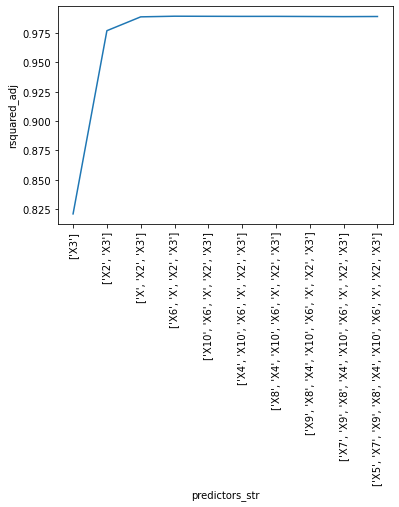

,rsquared_adj,predictors
4,0.989408,"[X6, X, X2, X3]"


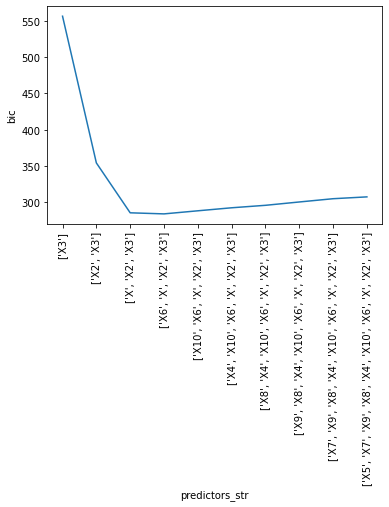

,bic,predictors
4,284.249198,"[X6, X, X2, X3]"


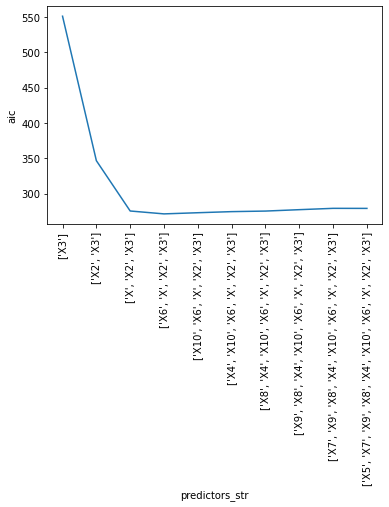

,aic,predictors
4,271.223347,"[X6, X, X2, X3]"


In [7]:
def forward_stepwise(X, y, scorer='ssr', results=[(0, [])]):
    """Perform forward stepwise variable selection as described in
    An Introductions to Statistical Learning (p.207)
    Returns pandas dataframe object  with results for each step"""
    # List predictors that havent's been used so far
    p_all    = list(X.columns)
    p_used   = results[-1][1]
    p_unused = [p for p in p_all if p not in p_used]
    
    # Job done, exit recursion
    if not p_unused:
        scores = [r[0] for r in results]
        preds  = [r[1] for r in results]
        return pd.DataFrame({scorer: scores, 'predictors': preds}).drop(0)
    
    # Get score for each possible additional predictor
    r = []
    for p in p_unused:
        f     = '{} ~ {}'.format(y.columns[0], '+'.join([p]+p_used))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r    += [(model, [p]+p_used)]
    
    # Choose predictor which yields best score
    if scorer == 'ssr':
        best_model = sorted(r, key=lambda tup: tup[0].ssr)[0]
        best_score = (best_model[0].ssr, best_model[1])
    elif scorer == 'rsquared_adj':
        best_model = sorted(r, key=lambda tup: tup[0].rsquared_adj)[-1]
        best_score = (best_model[0].rsquared_adj, best_model[1])        
    elif scorer == 'bic':
        best_model = sorted(r, key=lambda tup: tup[0].bic)[0]
        best_score = (best_model[0].bic, best_model[1]) 
    elif scorer == 'aic':
        best_model = sorted(r, key=lambda tup: tup[0].aic)[0]
        best_score = (best_model[0].aic, best_model[1]) 
                        
    new_results = results + [best_score]
    # Recursive call to self
    return forward_stepwise(X, y, scorer, new_results)
def backward_stepwise(X, y, scorer='ssr', results=[]):
    """Perform backward stepwise variable selection as described in
    An Introductions to Statistical Learning (p.209)
    Returns pandas dataframe object  with results for each step"""
    # List predictors that havent's been used so far
    p_all = list(X.columns)

    # Check if we're starting out here
    if not results:
        # Fit model with all features
        f     = '{} ~ {}'.format(y.columns[0], '+'.join(p_all))
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Begin backward stepwise recursion
        if scorer == 'ssr':
            return backward_stepwise(X, y, scorer, [(model.ssr, p_all)])
        if scorer == 'rsquared_adj':
            return backward_stepwise(X, y, scorer, [(model.rsquared_adj, p_all)])
        if scorer == 'bic':
            return backward_stepwise(X, y, scorer, [(model.bic, p_all)])
        if scorer == 'aic':
            return backward_stepwise(X, y, scorer, [(model.aic, p_all)])
    else:
        p_used = results[-1][1]
    
    # Job done, exit recursion
    if len(p_used) == 1:
        scores = [r[0] for r in results]
        preds  = [r[1] for r in results]
        return pd.DataFrame({scorer: scores, 'predictors': preds})    
    
    # Get rss score for each possible removed predictor
    r = []
    for p in p_used:
        p_test = [i for i in p_used if i != p]
        f     = '{} ~ {}'.format(y.columns[0], '+'.join(p_test))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r     += [(model, p_test)]
    
    # Choose removal of predictor which yields best score
    if scorer == 'ssr':
        best_model = sorted(r, key=lambda tup: tup[0].ssr)[0]
        best_score = (best_model[0].ssr, best_model[1])
    elif scorer == 'rsquared_adj':
        best_model = sorted(r, key=lambda tup: tup[0].rsquared_adj)[-1]
        best_score = (best_model[0].rsquared_adj, best_model[1])        
    elif scorer == 'bic':
        best_model = sorted(r, key=lambda tup: tup[0].bic)[0]
        best_score = (best_model[0].bic, best_model[1]) 
    elif scorer == 'aic':
        best_model = sorted(r, key=lambda tup: tup[0].aic)[0]
        best_score = (best_model[0].aic, best_model[1]) 

    new_results = results + [best_score]
    # Recursive call to self
    return backward_stepwise(X, y, scorer, new_results)


def subset_analysis(df, scorer):
    """Renders results from forward_stepwise() and backward_stepwise()"""
    df['predictors_str'] = df['predictors'].astype(str)
    
    ax = sns.lineplot(x='predictors_str', y=scorer, data=df, sort=False)
    plt.xticks(rotation=90)
    plt.show();
    
    if scorer == 'rsquared_adj':
        display(df[df[scorer] ==  df[scorer].max()].drop('predictors_str', axis=1))
    else:
        display(df[df[scorer] ==  df[scorer].min()].drop('predictors_str', axis=1))

#Forward Stepwise Selection
# adjr2
# ------------------------------------------------
display(HTML('<h4>Adjusted R^2</h4>'))
scorer = 'rsquared_adj'
subset_analysis(forward_stepwise(X, y, scorer=scorer), scorer)

# Bayes' Information Criteria (BIC)
# ------------------------------------------------
display(HTML('<h4>Bayes\' Information Criteria</h4>'))
scorer = 'bic'
subset_analysis(forward_stepwise(X, y, scorer=scorer), scorer)

# Akaike's Information Criteria (AIC/ C_p)
# ------------------------------------------------
display(HTML('<h4>Akaike\'s Information Criteria</h4>'))
scorer = 'aic'
subset_analysis(forward_stepwise(X, y, scorer=scorer), scorer)

#
# C:\Users\smtrp\OneDrive\Desktop\DS502\ISLR\HW_3\Ch6_P8_complete.ipynb
# C:\Users\smtrp\OneDrive\Desktop\DS502\ISLR\HW_3\Ch6_P8_complete.ipynb
# https://github.com/ACZD254/ISLR/blob/main/HW_3/Ch6_P8_complete.ipynb#L131

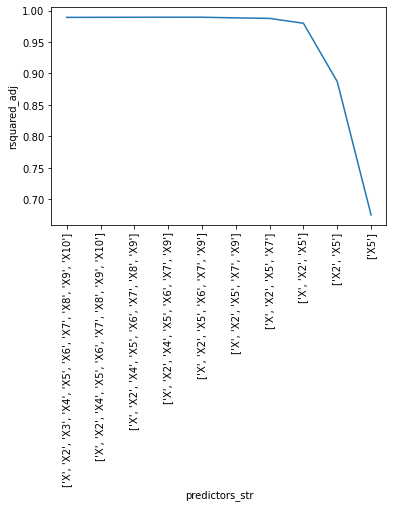

,rsquared_adj,predictors
3,0.989431,"[X, X2, X4, X5, X6, X7, X9]"


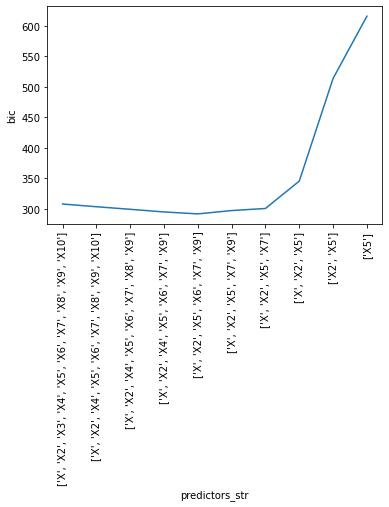

,bic,predictors
4,291.450514,"[X, X2, X5, X6, X7, X9]"


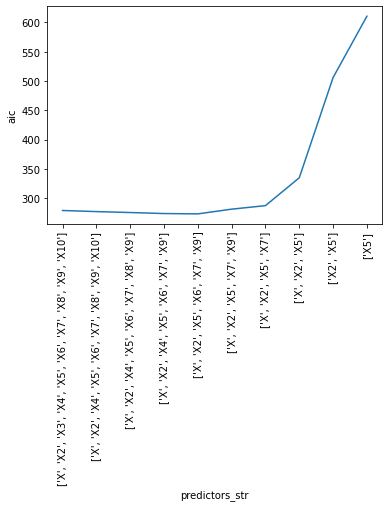

,aic,predictors
4,273.214322,"[X, X2, X5, X6, X7, X9]"


In [8]:
#Backward Stepwise Selection
# adjr2
# ------------------------------------------------
display(HTML('<h4>Adjusted R^2</h4>'))
scorer = 'rsquared_adj'
subset_analysis(backward_stepwise(X, y, scorer=scorer), scorer)

# Bayes' Information Criteria (BIC)
# ------------------------------------------------
display(HTML('<h4>Bayes\' Information Criteria</h4>'))
scorer = 'bic'
subset_analysis(backward_stepwise(X, y, scorer=scorer), scorer)

# Akaike's Information Criteria (AIC/ C_p)
# ------------------------------------------------
display(HTML('<h4>Akaike\'s Information Criteria</h4>'))
scorer = 'aic'
subset_analysis(backward_stepwise(X, y, scorer=scorer), scorer)

**Comment on findings**\
I prefer Forward simoply because its giving me less dimensionality to deal with in its best solutions for each category. 
However, quite interstingly, it all does chose the same model for all the categories. Which might be a very strong indicator that they are the right variables to choose or in the darker possibility - a bug. 
Bacward gives more diverse answers but I don't really like that fact that its always using >4 parameters for each category.

**e)**\
Fitting Lasso should reduce the dimentionality. Let's test that theory.


In [31]:
def lasso_cv(X, y, λ, k):
    """Perform the lasso with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Lasso(alpha=λ, fit_intercept=True, normalize=False, max_iter=1000000).fit(X_train, y_train)

        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test['y'])]
    return MSEs

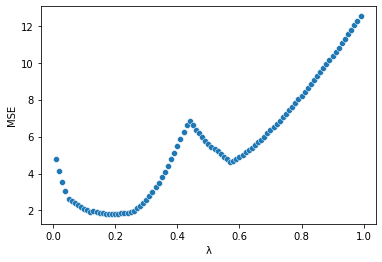

In [12]:
lambdas = np.arange(0.01, 1, 0.01)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X, y, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}));

**Comment on the plot**\
Beautiful Lasso plot. WE can see that the grap is closest to zero around 0.2 so that's where I expect to find our lambda value to fall. 

In [13]:
min(zip(MSEs, lambdas))

(1.8145436278959726, 0.19)

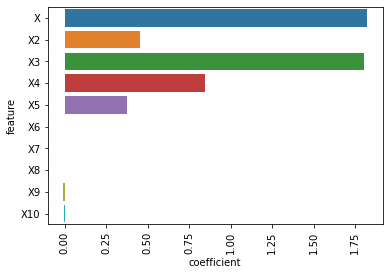

,feature,coefficient
0,X,1.823572
1,X2,0.454881
2,X3,1.802128
3,X4,0.847043
4,X5,0.373082
5,X6,0.000000
6,X7,0.000000
7,X8,-0.000000
8,X9,-0.009186
9,X10,-0.002988


In [14]:
lamb = min(zip(MSEs, lambdas))[1]
model = linear_model.Lasso(alpha=lamb, fit_intercept=True, normalize=False, max_iter=1000000).fit(X, y)
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
# plot
ax = sns.barplot(x='coefficient', y='feature', data=df);
plt.xticks(rotation=90)
plt.show();
display(df)

**Comment on findings**\
As expected, X6, X7 and X 8 have been driven to zero while X9 and X10 have been heavily minimised. Cool.

In [35]:
def mse(y_hat, y):
    """Calculate Mean Squared Error"""
    return np.sum(np.square(y_hat - y)) / y.size
def lasso_cv(X, y, λ, k):
    """Perform the lasso with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Lasso(alpha=λ, fit_intercept=True, normalize=True, max_iter=1000000).fit(X_train, y_train)

        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test['y'])]
    return MSEs



In [36]:
lambdas = np.arange(0.001, 0.01, 0.0001)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X, y, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}));

KeyboardInterrupt: 

In [16]:
min(zip(MSEs, lambdas))

(0.8894063503790948, 0.0022000000000000006)

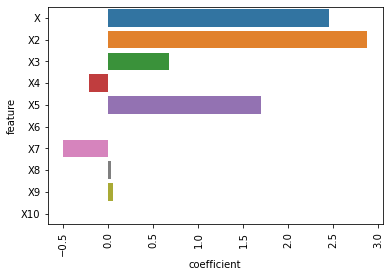

,feature,coefficient
0,X,2.446150
1,X2,2.876938
2,X3,0.678915
3,X4,-0.218099
4,X5,1.698335
5,X6,-0.000000
6,X7,-0.503101
7,X8,0.028357
8,X9,0.047248
9,X10,-0.003263


In [17]:
lamb = min(zip(MSEs, lambdas))[1]
model = linear_model.Lasso(alpha=lamb, fit_intercept=True, normalize=False, max_iter=1000000).fit(X, y)
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
# plot
ax = sns.barplot(x='coefficient', y='feature', data=df);
plt.xticks(rotation=90)
plt.show();
display(df)

So with feature normalisation, we achieved negative coefficients for three out of the six significant features selected. I don't know what to make of that.

**f)**\
So we are running the above steps once more? Great.

<AxesSubplot:>

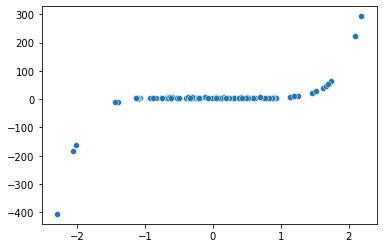

In [18]:
np.random.seed(1)
x   = np.random.normal(0, 1, 100)
eps = np.random.normal(0 ,1 , 100)

y_np = 5 + 1.2*(x**7) + eps

sns.scatterplot(x=x, y=y_np)

In [19]:
X = pd.DataFrame({'X': x,
                  'X2': x**2,
                  'X3': x**3,
                  'X4': x**4,
                  'X5': x**5,
                  'X6': x**6,
                  'X7': x**7,
                  'X8': x**8,
                  'X9': x**9,
                  'X10': x**10})
y = pd.DataFrame({'y': y_np})

**Best Subset Selection**

In [20]:
def min_rss(statsmodels):
    """Return model with lowest Residual Sum of Squares (RSS)"""
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]

def max_adjr2(statsmodels):
    """Return model with max R-squared"""
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]

def min_bic(statsmodels):
    """Return model with min Bayes' Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

def min_aic(statsmodels):
    """Return model with min Akaike's Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].aic)[0]


def get_models(k, X, y):
    """
    Fit all possible models that contain exactly k predictors.
    """
    # List all available predictors
    X_combos = itertools.combinations(list(X.columns), k)
    
    # Fit all models
    models = []
    for X_label in X_combos:
        # Parse patsy formula
        X_smf = ' + '.join(X_label)
        f     = '{} ~ {}'.format(y.columns[0], X_smf)
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Return results
        models += [(f, model)]
    return models


# Intended API
# ----------------------------------------------

def best_subset(X, y, scorer='ssr'):
    """Perform best subset selection using Residual Sum of Squares to
    select best model in each subset.
    Notes: highly computationally expensive for large number of features in  X
    Maxes out my laptop for p > 14"""
    # get all model results
    model_subsets = []
    for k in range(len(X.columns)):
        k=k+1
        subset = get_models(k, X, y)
        model_subsets += [subset]
        print('Best subset selected: k = {}/{}, done'.format(k, len(X.columns)))

    # Select best in each subset using chosen scorer
    if scorer == 'ssr':
        # Get best rss score for each subset
        return [min_rss(m) for m in model_subsets]
    elif scorer == 'rsquared_adj':
        # Get best rss score for each subset
        return [max_adjr2(m) for m in model_subsets]       
    elif scorer == 'bic':
        # Get best rss score for each subset
        return [min_bic(m) for m in model_subsets]
    elif scorer == 'aic':
        # Get best rss score for each subset
        return [min_aic(m) for m in model_subsets]

    
def cross_val(formula, X, y, k):
    """Perform k-fold cross validation to return mean MSE score
    Expects formula as Patsy formula"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = smf.ols(formula=formula, data=pd.concat([X_train, y_train], axis=1)).fit()
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test['y'])]
    return (MSEs, formula)

In [21]:
# get all model results
best_subset_models = best_subset(X, y, scorer='bic')

Best subset selected: k = 1/10, done
Best subset selected: k = 2/10, done
Best subset selected: k = 3/10, done
Best subset selected: k = 4/10, done
Best subset selected: k = 5/10, done
Best subset selected: k = 6/10, done
Best subset selected: k = 7/10, done
Best subset selected: k = 8/10, done
Best subset selected: k = 9/10, done
Best subset selected: k = 10/10, done


,formula,mse
2,y ~ X2 + X6 + X7,0.854173


Intercept    5.271801
X2          -0.320021
X6           0.020727
X7           1.203961
dtype: float64

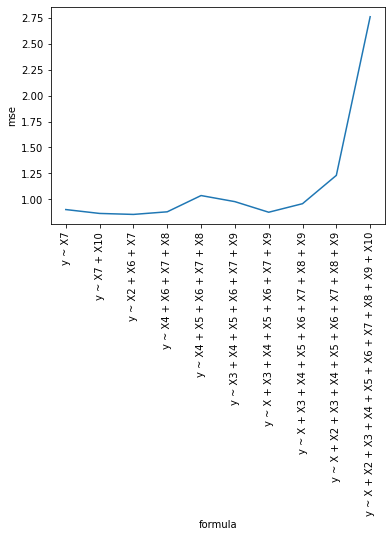

In [22]:
# Parse results
best_subset_formula = [f[0] for f in best_subset_models]
best_subset_mses    = [np.mean(cross_val(f, X, y, 10)[0]) for f in best_subset_formula]
df = pd.DataFrame({'formula': best_subset_formula, 'mse': best_subset_mses})

# Show chosen model
display(df[df['mse'] == df['mse'].min()])
best_subset_params = best_subset_models[2][1].params
display(best_subset_params)

# Plot mse across subsets
ax = sns.lineplot(x='formula', y='mse', data=df, sort=False)
plt.xticks(rotation=90)
plt.show();

<AxesSubplot:>

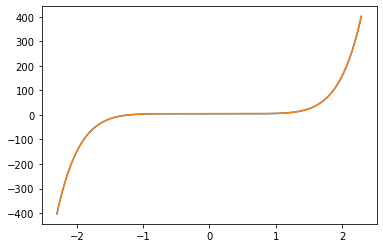

In [23]:
x = np.arange(-2.3, 2.3, 0.01)
sns.lineplot(x=x, y=5 + 1.2*(x**7))
sns.lineplot(x=x, y=5.27 - 0.32*(x**2) + 0.02*(x**6) + 1.20*(x**7))

In [24]:
def lasso_cv(X, y, λ, k):
    """Perform the lasso with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Lasso(alpha=λ, fit_intercept=True, normalize=True, max_iter=1000000).fit(X_train, y_train)

        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test['y'])]
    return MSEs

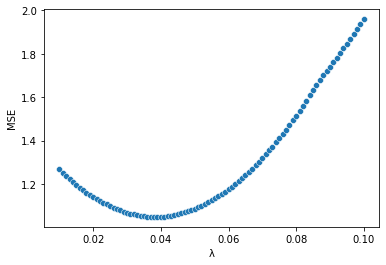

In [25]:
lambdas = np.arange(0.01, 0.1, 0.001)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X, y, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}));

In [26]:
min(zip(MSEs, lambdas))

(1.0480683621469287, 0.03799999999999998)

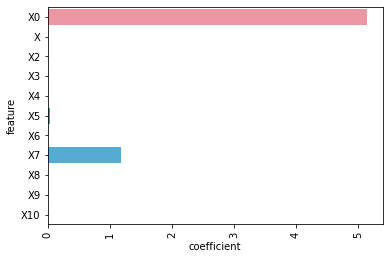

,feature,coefficient
0,X0,5.139609
1,X,0.000000
2,X2,-0.000000
3,X3,0.000000
4,X4,0.000000
5,X5,0.038360
6,X6,0.000000
7,X7,1.186933
8,X8,0.000000
9,X9,0.000000


In [27]:
# What coefficients does the lasso choose for the optimal lambda value?
λ = min(zip(MSEs, lambdas))[1]
model = linear_model.Lasso(alpha=λ, fit_intercept=True, normalize=True, max_iter=1000000).fit(X, y)
intercept  = pd.DataFrame({'feature': 'X0', 'coefficient': model.intercept_})
lasso_a_df = intercept.append(pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_}), ignore_index=True)
ax = sns.barplot(x='coefficient', y='feature', data=lasso_a_df);
plt.xticks(rotation=90)
plt.show();

display(lasso_a_df)


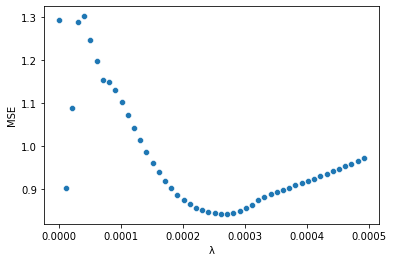

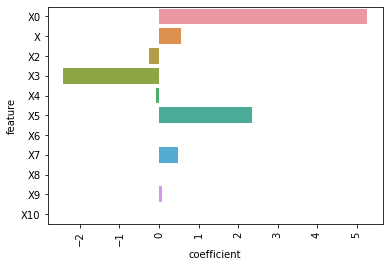

,feature,coefficient
0,X0,5.275241
1,X,0.546472
2,X2,-0.261390
3,X3,-2.428896
4,X4,-0.088259
5,X5,2.363543
6,X6,0.000000
7,X7,0.469777
8,X8,0.006829
9,X9,0.071042


In [28]:
lambdas = np.arange(0.000001, 0.0005, 0.00001)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X, y, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}))
plt.show();

# What coefficients does the lasso choose for the optimal lambda value?
λ = min(zip(MSEs, lambdas))[1]
model = linear_model.Lasso(alpha=λ, fit_intercept=True, normalize=True, max_iter=1000000).fit(X, y)
intercept  = pd.DataFrame({'feature': 'X0', 'coefficient': model.intercept_})
lasso_b_df = intercept.append(pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_}), ignore_index=True)
ax = sns.barplot(x='coefficient', y='feature', data=lasso_b_df);
plt.xticks(rotation=90)
plt.show();

display(lasso_b_df)


In [29]:
min(zip(MSEs, lambdas))

(0.842302578493106, 0.00026100000000000006)

In [30]:
x   = np.random.normal(0, 1, 100)
X = pd.DataFrame({'X': x,
                  'X2': x**2,
                  'X3': x**3,
                  'X4': x**4,
                  'X5': x**5,
                  'X6': x**6,
                  'X7': x**7,
                  'X8': x**8,
                  'X9': x**9,
                  'X10': x**10})
X_np = np.insert(np.array(X), 0, 1, axis=1)

y_actual = 5 + 1.2*(x**7)
bss_params = np.zeros(11)
bss_params[0] = best_subset_params[0]
bss_params[2] = best_subset_params[1]
bss_params[6] = best_subset_params[2]
bss_params[7] = best_subset_params[3]

lasso_a_params = np.array(lasso_a_df['coefficient'])
lasso_b_params = np.array(lasso_b_df['coefficient'])
y_bss     = X_np @ bss_params
y_lasso_a = X_np @ lasso_a_params
y_lasso_b = X_np @ lasso_b_params
def mse(y_hat, y):
    """Calculate Mean Squared Error"""
    return np.sum(np.square(y_hat - y)) / y.size
display(HTML('<h4>Actual MSEs compared to known f(x)</h4>'))
print('Best subset selection    : {}'.format(mse(y_bss, y_actual)))
print('Lasso a (higher lambda)  : {}'.format(mse(y_lasso_a, y_actual)))
print('Lasso b (lower lambda ~0): {}'.format(mse(y_lasso_b, y_actual)))

Best subset selection    : 0.5015558203751351
Lasso a (higher lambda)  : 0.23328025069876512
Lasso b (lower lambda ~0): 5.483599366481567


**Comments on Findings**\
Here we used three seperate approaches to estimate the mode f(x) in a simulated context with noise added. We tested the estimated model for each aproach against the true f(x) without noise.

Best subset selection and ridge-regression (lasso b) produced the lowest CV mse, but lasso a achieved the lowest MSE when compared with the true model f(x). The lasso a was also most effective at ignoring superfluous feautures as it essentially drove them to zero.